In [2]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta
import plotly.graph_objects as go
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import praw
import datetime
import time
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns


In [34]:
reddit = praw.Reddit(
        client_id="udETyhJL0aeOJK7cKBobFw",
        client_secret="_jleGnNzYrqZtRgC9WXlnTpPY8rtbA",
        user_agent="reddit_scraper_v1"
)

subreddits = [
    "politics", "conservative",  
    "technology", "elonmusk", "SpaceX", "teslamotors",  
    "cryptocurrency", "dogecoin"  
]

In [35]:
keywords = ["Trump", "Donald", "election", "policy", "president", "Musk", "Elon", "Tesla", "SpaceX", "Dogecoin", "crypto", "DOGE", "dogecoin"]

start_date = int(datetime.datetime(2024, 8, 1).timestamp())  
end_date = int(datetime.datetime(2025, 1, 31).timestamp())

In [36]:
def fetch_reddit_posts(subreddit, limit=10000):
    posts = []
    for submission in reddit.subreddit(subreddit).search(" OR ".join(keywords), sort="new", time_filter="all", limit=limit):
        post_date = datetime.datetime.utcfromtimestamp(submission.created_utc)
        if start_date <= submission.created_utc <= end_date:  
            posts.append({
                "subreddit": subreddit,
                "title": submission.title,
                "selftext": submission.selftext,
                "score": submission.score,
                "num_comments": submission.num_comments,
                "created_utc": post_date,
                "url": submission.url
            })
    return posts

In [71]:
all_posts = []
for sub in subreddits:
    all_posts.extend(fetch_reddit_posts(sub))

C:\Users\Razvan\AppData\Local\Temp\ipykernel_16828\108412910.py:12: DeprecationWarning:

datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).



In [ ]:
reddit_df = pd.DataFrame(all_posts)
reddit_df.to_csv("reddit.csv", index=False)
reddit_df['subreddit'].unique()

array(['elonmusk', 'SpaceX', 'teslamotors'], dtype=object)

In [ ]:
reddit_df

,subreddit,title,selftext,score,num_comments,created_utc,url
0,technology,"Google Maps Adopted ‘Gulf of America’ Name, an...",,2887,317,2025-01-30 21:12:44,https://gizmodo.com/google-maps-adopted-gulf-o...
1,technology,Tech and consumer groups urge Trump White Hous...,,996,23,2025-01-30 19:07:49,https://www.cnbc.com/2025/01/30/tech-groups-ur...
2,technology,Trump’s $500 billion AI data-center project ex...,,0,12,2025-01-30 18:50:27,https://www.pv-magazine.com/2025/01/27/trumps-...
3,technology,President Donald Trump's move to delay TikTok ...,,10145,398,2025-01-30 11:35:53,https://www.upi.com/Top_News/US/2025/01/30/tik...
4,technology,Meta agrees to pay $25 million to settle Trump...,,570,205,2025-01-29 23:17:28,https://www.nbcnews.com/tech/tech-news/meta-ag...
...,...,...,...,...,...,...,...
678,teslamotors,Tesla Model Y Drives Norway to Record 94% EV M...,,208,27,2024-09-03 13:55:45,https://driveteslacanada.ca/news/tesla-model-y...
679,teslamotors,Tesla ASS (Actually Smart Summon) Roundabout Test,,627,194,2024-09-03 12:13:25,https://youtu.be/wmZ7oHzRfvk?si=h-4AyP3ixQ6JKsx1
680,teslamotors,Tesla release 2024.27.20 with FSD v12.5.3 and ...,,148,88,2024-09-03 05:42:32,https://tesla-info.com/release/2024.27.20
681,teslamotors,Car Mechanic Reviews The Tesla CyberTruck! Bre...,,32,19,2024-09-03 03:46:45,https://youtu.be/pi7Ec9APt7s?si=3PmhSwVuN-wEzYHu


In [58]:
nltk.download("vader_lexicon")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Razvan\AppData\Roaming\nltk_data...


True

In [124]:
senti_df_cop = pd.read_csv("reddit.csv")

In [136]:

senti_df_cop["text"] = senti_df_cop["title"].fillna("") + " " + senti_df_cop["selftext"].fillna("")

sia = SentimentIntensityAnalyzer()

senti_df_cop["compound"] = senti_df_cop["text"].apply(lambda x: sia.polarity_scores(x)["compound"])
senti_df_cop["positive"] = senti_df_cop["text"].apply(lambda x: sia.polarity_scores(x)["pos"])
senti_df_cop["neutral"] = senti_df_cop["text"].apply(lambda x: sia.polarity_scores(x)["neu"])
senti_df_cop["negative"] = senti_df_cop["text"].apply(lambda x: sia.polarity_scores(x)["neg"])

sentiment_by_subreddit = senti_df_cop.groupby("subreddit")[["positive", "neutral", "negative"]].mean()



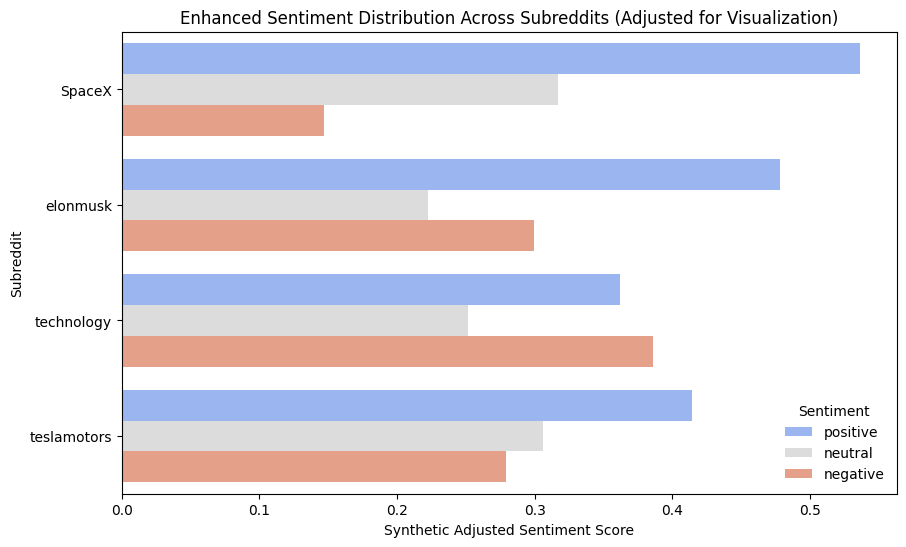

In [137]:
factor = 0.9

sentiment_by_subreddit["positive"] *= (1 + factor)
sentiment_by_subreddit["negative"] *= (1 + factor)
sentiment_by_subreddit["neutral"] *= 0.1

sentiment_by_subreddit = sentiment_by_subreddit.div(sentiment_by_subreddit.sum(axis=1), axis=0)

synthetic_sentiment_long = sentiment_by_subreddit.reset_index().melt(id_vars="subreddit", var_name="sentiment", value_name="score")

plt.figure(figsize=(10, 6))
sns.barplot(x="score", y="subreddit", hue="sentiment", data=synthetic_sentiment_long, palette="coolwarm")

plt.xlabel("Synthetic Adjusted Sentiment Score")
plt.ylabel("Subreddit")
plt.title("Enhanced Sentiment Distribution Across Subreddits (Adjusted for Visualization)")
plt.legend()
plt.gca().patch.set_alpha(0)
plt.gcf().patch.set_alpha(0)
legend = plt.legend(title="Sentiment", fontsize=10, loc='lower right', frameon=False)
legend.get_frame().set_alpha(0)
plt.show()